In [1]:
import tensorflow as tf 
tf.enable_eager_execution()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [3]:
dataset = np.load('dsprites-dataset/dsprites_multiple_shapes_no_color.npz.npy')

In [4]:
def show_images_grid(imgs_, num_images=25):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

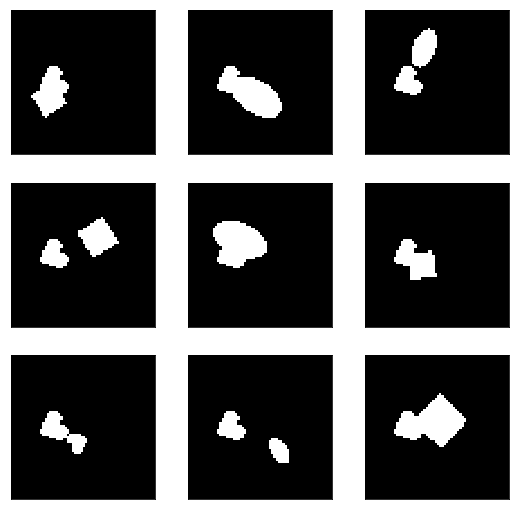

In [5]:
show_images_grid(np.squeeze(dataset), 9)

In [6]:
dataset = dataset[100000:200000].astype('float32')

In [7]:
save_path = 'save/VAEMultipleShapesNoColor'

In [13]:
class VAESprite(tf.keras.Model):
    """Same Architecture"""
    def __init__(self, latent_dim, num_object):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_object = num_object
        
        self.encoder1 = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(64, 64, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=(1, 1), activation=tf.nn.elu),
        ])
        
        self.encoder2 = tf.keras.Sequential([       
            tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=24, kernel_size=1, strides=(1, 1), activation=tf.nn.elu),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=4*4*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(4, 4, 64)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=1, strides=(1, 1), padding="SAME"),
        ])
    
    def call(self, img, is_sigmoid=False):
        """Reuse the code from the Google Example"""
        encoder1 = self.encoder1(img)
        
        # Adding x, y coordinate
        x = tf.convert_to_tensor([-14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 
                                  0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])/15
        y = tf.convert_to_tensor([-14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 
                                  0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])/15
        
        X, Y = tf.meshgrid(x, y)
        X, Y = tf.expand_dims(tf.cast(X, tf.float32), -1), tf.expand_dims(tf.cast(Y, tf.float32), -1)
        X, Y = tf.expand_dims(tf.cast(X, tf.float32), 0), tf.expand_dims(tf.cast(Y, tf.float32), 0)
        
        X, Y = tf.tile(X, [encoder1.shape[0], 1, 1, 1]), tf.tile(X, [encoder1.shape[0], 1, 1, 1])
        
        encoder_pos = tf.concat([encoder1, X, Y], -1)
        encoder_final = self.encoder2(encoder_pos)
        
        encoder_flatten = tf.reshape(encoder_final, (tf.shape(encoder_final)[0], 
                                                    -1, tf.shape(encoder_final)[-1]))
        mean, log_var = tf.split(encoder_flatten, num_or_size_splits=2, axis=-1)
        
        # Getting Analytic-KL
        kl = 0.5 * tf.reduce_sum(tf.exp(log_var) + mean**2 - 1. - log_var, axis=[-1])
        total_kl_value, total_kl_index = tf.math.top_k(kl, k=self.num_object)
        
        # Getting top 2
        top_latent_mean = tf.batch_gather(mean, total_kl_index)
        top_latent_log_var = tf.batch_gather(log_var, total_kl_index)
        
        # Getting latents for each objects 
        normal = tf.random_normal(shape=top_latent_mean.shape)
        each_latent = normal * tf.exp(top_latent_log_var * .5) + top_latent_mean
        
        # Should I do this ? 
        latents = tf.reshape(each_latent, (-1, self.latent_dim))
        decoded = self.decoder(latents)
        
        imgs = tf.reshape(decoded, (-1, self.num_object, decoded.shape[1], 
                                       decoded.shape[2], decoded.shape[3]))
        
        # Add all images 
        final_images = tf.reduce_sum(imgs, axis=1)
        return each_latent, final_images, top_latent_mean, top_latent_log_var, kl

In [14]:
vae = VAESprite(12, 2)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
saver = tf.train.Checkpoint(optimizer=optimizer,
                            model=vae,
                            optimizer_step=tf.train.get_or_create_global_step())
saver.restore(tf.train.latest_checkpoint(save_path))

In [15]:
index_test = 124

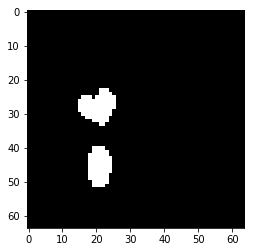

In [16]:
plt.imshow(np.squeeze(dataset[index_test]), cmap='Greys_r',  interpolation='nearest')

In [17]:
each_latent, final_img, _, _, kl_map = vae(tf.convert_to_tensor([dataset[index_test]]))
final = tf.squeeze(final_img)

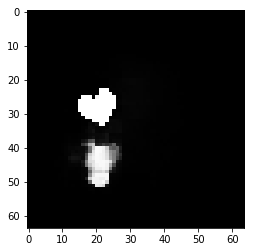

In [18]:
plt.imshow(tf.nn.sigmoid(final).numpy(), cmap='Greys_r',  interpolation='nearest')

In [19]:
latent_1 = each_latent.numpy()[:, 0, :]
latent_2 = each_latent.numpy()[:, 1, :]

In [20]:
object1 = tf.nn.sigmoid(vae.decoder(tf.convert_to_tensor(latent_1)))
object2 = tf.nn.sigmoid(vae.decoder(tf.convert_to_tensor(latent_2)))

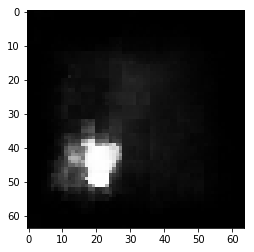

In [21]:
plt.imshow(tf.squeeze(object1).numpy(), cmap='Greys_r',  interpolation='nearest')

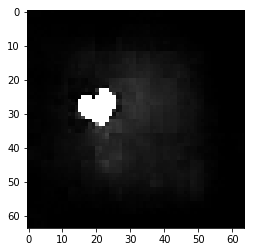

In [22]:
plt.imshow(tf.squeeze(object2).numpy(), cmap='Greys_r',  interpolation='nearest')

In [23]:
def get_kl_attention_map(kl_index):
    batch_size = kl_index.shape[0]
    blank_map = np.zeros((batch_size, 14*14))
    for i in range(batch_size):
        blank_map[i] = kl_index[i]
    return blank_map.reshape(batch_size, 14, 14)

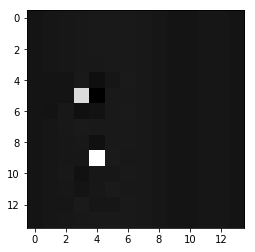

In [24]:
plt.imshow(get_kl_attention_map(kl_map)[0], cmap='Greys_r')

In [25]:
def traverse_latent(latent, axis, traverse_length=4.5, total_step=9):
    step_size = traverse_length * 2 / total_step
    item = latent[:, axis]
    
    item_evolution = []
    item = item - traverse_length
    import copy
    for i in range(total_step):
        new_latent = copy.deepcopy(latent)
        new_latent[:, axis] = item
        item_evolution.append(new_latent)
        item += step_size
        
    traversed_latent = np.squeeze(np.stack(item_evolution))
    return traversed_latent

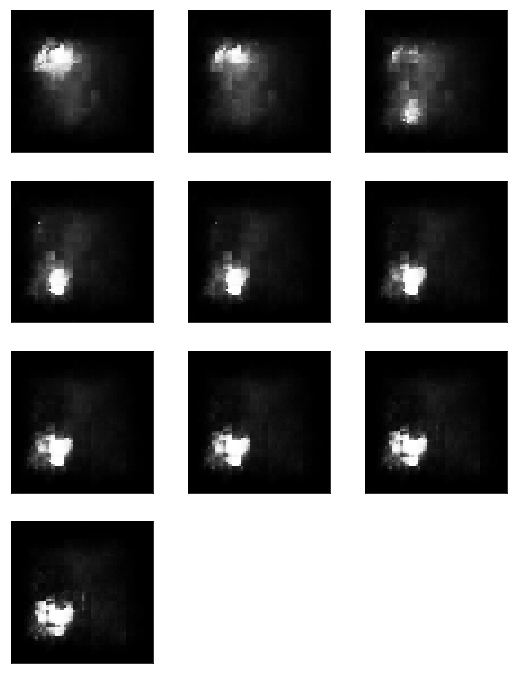

In [26]:
all_latent = traverse_latent(latent_1, 0, total_step=10)
all_object_1 = tf.nn.sigmoid(vae.decoder(tf.convert_to_tensor(all_latent)))
show_images_grid(tf.squeeze(all_object_1).numpy(), 10)

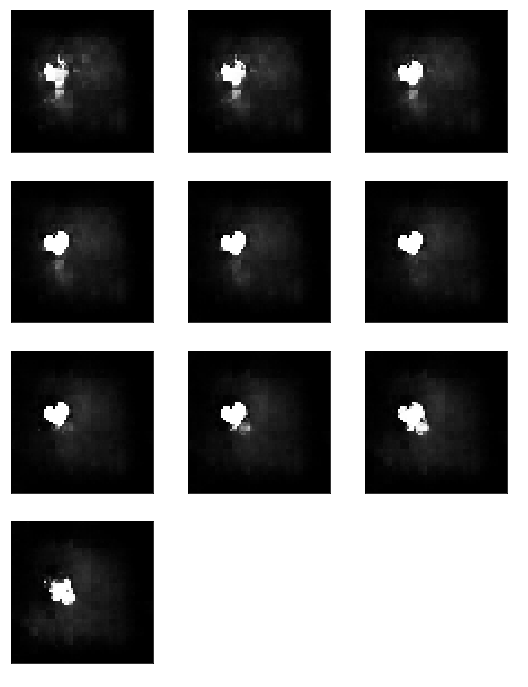

In [27]:
all_latent_2 = traverse_latent(latent_2, 0, total_step=10)
all_object_2 = tf.nn.sigmoid(vae.decoder(tf.convert_to_tensor(all_latent_2)))
show_images_grid(tf.squeeze(all_object_2).numpy(), 10)